In [92]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
eqsys = pyequion2.EquilibriumBackend(["Ca", "C", "Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="DEBYE")

In [89]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'C':0.065, 'Ca':0.028, 'Na':0.075, 'Cl':0.056}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Calcite"],
                           kreaction="inf", flux_residual_tol=1e-3)
builder.make_grid(20, 3)
builder.set_species()

In [90]:
builder.set_initial_guess_from_bulk()

In [91]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success#, solfull.success

True

In [86]:
sol = builder.solve_gem_lagrangian(options={'verbose':2})

/home/dfnaiff/miniconda3/envs/mainenv/lib/python3.9/site-packages/scipy/optimize/_minimize.py:527: RuntimeWarning: Method TNC does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | +3.0566e-02 | 1.00e+00 | 4.27e+03 | 0.00e+00 |
|   2   |   2   |  142  | +3.0566e-02 | 1.00e-01 | 4.27e+03 | 0.00e+00 |
|   3   |   2   |  284  | +3.0566e-02 | 1.00e-02 | 4.27e+03 | 0.00e+00 |
|   4   |   2   |  426  | +3.0566e-02 | 1.00e-03 | 4.27e+03 | 0.00e+00 |
|   5   |   2   |  568  | +3.0566e-02 | 1.00e-04 | 4.27e+03 | 0.00e+00 |
|   6   |   2   |  710  | +3.0566e-02 | 1.00e-05 | 4.27e+03 | 0.00e+00 |
|   7   |   2   |  852  | +3.0566e-02 | 2.03e-06 | 4.27e+03 | 0.00e+00 |
|   8   |   3   |  987  | +3.0566e-02 | 1.01e-06 | 4.27e+03 | 0.00e+00 |
|   9   |   4   | 1031  | +3.0566e-02 | 5.07e-07 | 4.27e+03 | 0.00e+00 |
|  10   |   5   | 1038  | +3.0222e-02 | 5.07e-07 | 4.69e+03 | 0.00e+00 |
|  11   |   6   | 1047  | +3.0222e-02 | 2.54e-07 | 4.69e+03 | 0.00e+00 |
|  12   |   7   | 1050  | +3.0222e-02 | 1.27e-07 | 

In [87]:
sol

         cg_niter: 1053
     cg_stop_cond: 2
           constr: []
      constr_nfev: []
      constr_nhev: []
      constr_njev: []
   constr_penalty: 1.0
 constr_violation: 0
   execution_time: 3.1407487392425537
              fun: array(0.03022218, dtype=float32)
             grad: array([-6.49633110e-01,  1.01519518e-01, -2.46293858e-01,  1.35207272e+00,
       -3.14516455e-01, -3.66316974e-01,  3.27591956e-01, -3.35274071e-01,
        4.37988669e-01, -4.99747336e-01,  3.46332312e-01, -2.48605311e-01,
        4.72660899e-01, -5.27601182e-01, -3.34322214e-01,  3.26182580e+00,
       -5.24070215e+00, -1.15975475e+00,  8.06170368e+00, -4.38191938e+00,
        3.81115580e+00,  1.26955854e-02, -5.04227690e-02,  7.46403486e-02,
        1.73372194e-01, -4.99764830e-01,  9.31561738e-02, -1.32326603e+00,
        9.45649529e+00, -1.80483742e+01, -1.13323793e+01,  9.43716354e+01,
       -1.48435120e+02,  9.20289078e+01, -1.24221268e+01,  5.06225853e+01,
       -8.76546860e+01,  1.04509621e+01

In [88]:
sol.fun

array(0.03022218, dtype=float32)

In [77]:
logcmu = builder.x.numpy().reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

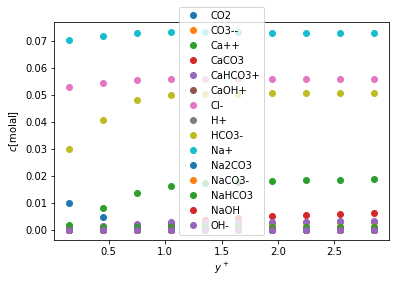

In [78]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

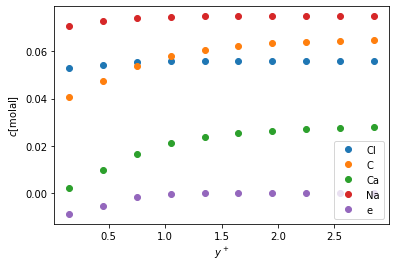

In [79]:
cel = builder.reduced_formula_matrix.numpy()@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

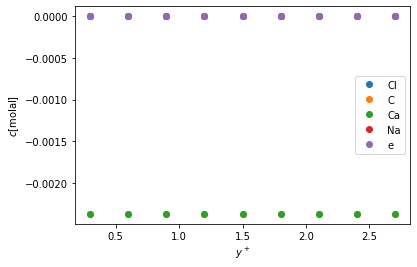

In [80]:
fluxes = builder.fluxes().detach().numpy()
yplot = builder.ypoints[1:-1].detach().numpy()
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(yplot, fluxes[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [81]:
4/(1e-2)*builder.fluxes()

tensor([[ 2.5823e-06, -2.0405e-06, -2.8793e-07,  2.7433e-06, -5.1488e-06,
          3.9256e-06,  7.5225e-06,  6.3107e-06, -1.0370e-05],
        [-9.4800e-01, -9.4800e-01, -9.4801e-01, -9.4800e-01, -9.4801e-01,
         -9.4801e-01, -9.4801e-01, -9.4800e-01, -9.4801e-01],
        [-9.4800e-01, -9.4801e-01, -9.4800e-01, -9.4800e-01, -9.4800e-01,
         -9.4800e-01, -9.4801e-01, -9.4801e-01, -9.4801e-01],
        [ 2.1462e-06,  5.0515e-06, -2.8739e-06,  1.9680e-06,  4.9794e-06,
         -1.3924e-06,  3.8616e-06,  1.1613e-06, -1.7024e-05],
        [-1.2148e-06,  4.4754e-06,  3.6700e-07, -1.3742e-06,  1.8896e-05,
         -5.0602e-06, -4.6613e-06, -1.3196e-05,  7.8273e-06]])